**LAB 08 - Time Frequency Analysis of Respiratory Sound Database (Kaggle)**

**Muhammad Zeyyan - 231209, Saleha Zahid -231209, Talha Iqbal - 231223, Isfah Anmol - 231207**

In [ ]:
!pip install --quiet EMD-signal PyEMD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0 requires multiprocess<0.70.17, but you have multiprocess 0.70.18 which is incompatible.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import pywt
from google.colab import drive
import glob
from scipy.signal import resample_poly
from scipy.signal import hilbert
from PyEMD import EMD
from math import gcd

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database'
AUDIO_PATH = os.path.join(DATASET_PATH, 'audio_and_txt_files')

Choosing one file to analyze

In [ ]:
# Pick first WAV
wav_files = sorted(glob.glob(os.path.join(AUDIO_PATH, '*.wav')))
if len(wav_files) == 0:
    raise FileNotFoundError("No WAV files found in folder.")
file_path = wav_files[0]
print("Using file:", file_path)

Using file: /content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav


Converting to mono incase stereo

In [ ]:
# Load audio
fs, sig = wavfile.read(file_path)
if sig.ndim > 1:
    sig = sig.mean(axis=1)
sig = sig.astype(np.float32)
sig /= (np.max(np.abs(sig)) + 1e-16)
t = np.arange(len(sig)) / fs
print(f"fs={fs} Hz, duration={len(sig)/fs:.2f} s")

fs=44100 Hz, duration=20.00 s


# **Part 1 – Short-Time Fourier Transform (STFT)**

In [ ]:
nperseg = 512            # increase window for better freq resolution (try 256/512/1024)
noverlap = nperseg // 2

In [ ]:
f, time, Zxx = signal.stft(sig, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')
S = np.abs(Zxx)

In [ ]:
# convert to dB
eps = 1e-12
S_db = 20 * np.log10(S + eps)

# dynamic range: show max down to max-80 dB
vmax = np.max(S_db)
vmin = vmax - 80

In [ ]:
# Choose upper frequency limit for display (respiratory sounds -> low freq)
fmax_display = min(4000, fs/2)   # you can change 2000 or 4000 depending on your data

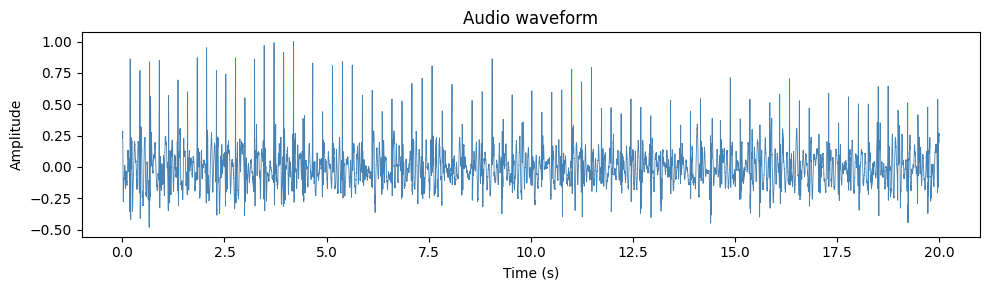

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(t, sig, color='steelblue', linewidth=0.6)
plt.title("Audio waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

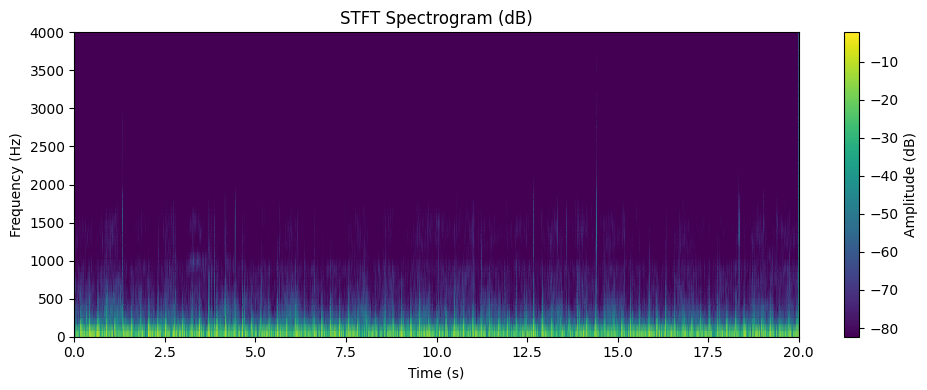

In [ ]:
plt.figure(figsize=(10,4))
pcm = plt.pcolormesh(time, f, S_db, shading='gouraud', cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("STFT Spectrogram (dB)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.ylim(0, fmax_display)
cbar = plt.colorbar(pcm, label='Amplitude (dB)')
plt.tight_layout()
plt.show()

# **Part 2 – Continuous Wavelet Transform (CWT)**

Downsampling because colab runtime was crashing .  

In [ ]:
def safe_cwt_and_plot(sig, fs,
                      target_fs=4000,   # downsample to this fs for CWT
                      max_duration=10.0, # seconds to keep from start
                      n_bins=50,        # number of frequency bins (scales)
                      wavelet='morl'):
    """
    Safe CWT: downsample + trim to avoid huge memory use in pywt.cwt.
    Plots waveform and CWT scalogram (dB).
    """
    # 1) Trim signal to max_duration (if longer)
    max_samples = int(min(len(sig), int(max_duration * fs)))
    sig_trim = sig[:max_samples]

    # 2) Downsample to target_fs if needed
    if fs != target_fs:
        # Use resample_poly for good quality: up=target_fs, down=fs simplified by ratio
        # Compute integer ratio close to target_fs/fs: up = target_fs, down = fs (works fine)
        up = int(target_fs)
        down = int(fs)
        # To avoid very large up/down, reduce ratio by gcd
        from math import gcd
        g = gcd(up, down)
        up //= g
        down //= g
        sig_ds = resample_poly(sig_trim, up, down).astype(np.float32)
        fs_new = int(round(fs * (up/down)))  # approximate new fs
        fs_new = target_fs  # we want to treat as target_fs for plotting
    else:
        sig_ds = sig_trim.astype(np.float32)
        fs_new = fs

    t = np.arange(len(sig_ds)) / fs_new
    print(f"CWT input: {len(sig_ds)} samples, fs={fs_new} Hz, duration={len(sig_ds)/fs_new:.2f} s")

    # 3) Build frequency vector (avoid 1..Nyquist with too many bins)
    fmin = 20.0
    fmax = min(2000.0, fs_new / 2.0)   # respiratory sounds often <2000 Hz
    freqs = np.linspace(fmin, fmax, n_bins)

    # 4) Convert frequencies -> scales for pywt.cwt
    center_freq = pywt.central_frequency(wavelet)
    scales = center_freq * fs_new / freqs

    # 5) Run CWT with try/except to catch MemoryError
    try:
        coeffs, frequencies = pywt.cwt(sig_ds, scales, wavelet, sampling_period=1.0/fs_new)
    except MemoryError:
        print("MemoryError: reduce 'n_bins', lower 'target_fs' or 'max_duration' and try again.")
        return
    except Exception as e:
        print("CWT failed:", e)
        return

    # 6) Convert to dB for visualization
    eps = 1e-12
    coeffs_mag = np.abs(coeffs)
    coeffs_db = 20 * np.log10(coeffs_mag + eps)
    vmax = np.max(coeffs_db)
    vmin = vmax - 70  # show dynamic range of 70 dB (adjustable)

    # 7) Plot waveform and scalogram
    plt.figure(figsize=(10,3))
    plt.plot(t, sig_ds, color='steelblue', linewidth=0.6)
    plt.title("Trimmed & Downsampled Waveform (for CWT)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    pcm = plt.pcolormesh(t, frequencies, coeffs_db, shading='gouraud', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"CWT Scalogram (Morlet) — {int(fmin)}-{int(fmax)} Hz")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.ylim(frequencies.min(), frequencies.max())
    plt.colorbar(pcm, label='Amplitude (dB)')
    plt.tight_layout()
    plt.show()

CWT input: 40000 samples, fs=4000 Hz, duration=10.00 s


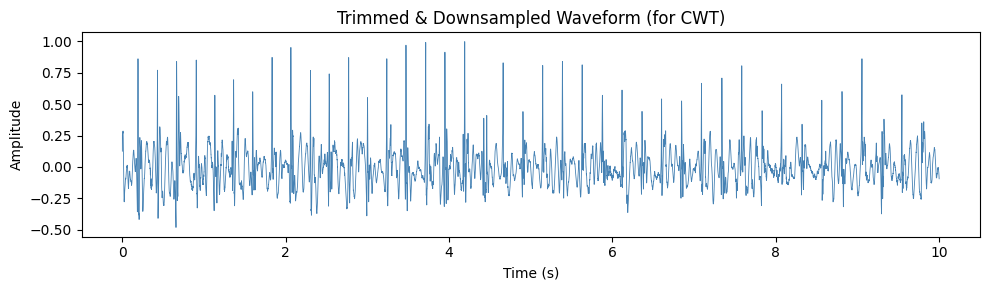

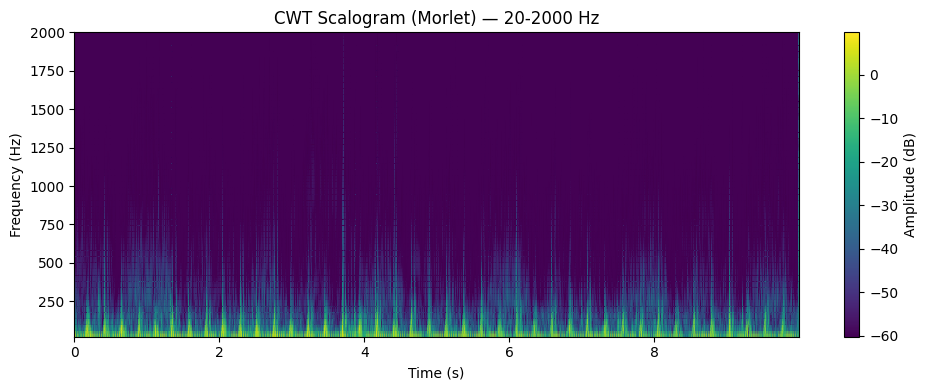

In [ ]:
safe_cwt_and_plot(sig, fs, target_fs=4000, max_duration=10.0, n_bins=50, wavelet='morl')

## Discussion Questions

### 1. How does window size affect the STFT’s time–frequency trade-off?
In the Short-Time Fourier Transform (STFT), the choice of window size controls the balance between time and frequency resolution.

- Smaller window → better time resolution, poorer frequency resolution.  
- Larger window → better frequency resolution, poorer time resolution.

For respiratory sounds, a medium window size (e.g., 512–1024 samples) offers a good compromise, allowing visualization of both transient wheezes and low-frequency breathing components.

---

### 2. Why does the CWT show sharper timing for transient events?
The Continuous Wavelet Transform (CWT) uses wavelets that automatically adapt their duration based on frequency.

- High frequencies use shorter wavelets, giving better time localization.  
- Low frequencies use longer wavelets, giving better frequency resolution.

Because of this adaptive behavior, the CWT provides sharper timing for transient events (such as crackles or coughs) than the STFT, which uses a fixed window for all frequencies.

---

### 3. Which transform would you choose for analysing step detection in gait data?
For step detection, the CWT is generally preferred.

- Steps are transient and repetitive events, and CWT captures both their timing and frequency variations accurately.  
- STFT can help analyze steady rhythms but may blur short impacts due to its fixed window size.

Therefore, CWT is better suited for transient detection (like steps or impacts), while STFT is more appropriate for analyzing continuous periodic signals.


# **Part 3 – Hilbert–Huang Transform (HHT))**

In [ ]:
import time

In [ ]:
target_fs = 1000           # DOWNsample to this (Hz). 1000 is usually enough for respiratory sounds.
max_duration = 5.0         # trim to this many seconds from start (reduces EMD time)
max_imf = 4                # limit IMFs extracted (None => unlimited)
energy_win_ms = 200        # window for short-time energy (ms) used to find active region
energy_threshold = 0.15    # fraction of max energy to consider region as 'active'
n_imfs_to_plot = 4
spectrum_point_size = 6

In [ ]:
if 'sig' not in globals() or 'fs' not in globals():
    from scipy.io import wavfile
    if 'file_path' not in globals():
        raise RuntimeError("No audio loaded and no file_path found. Please run the audio-loading cell first.")
    fs, sig = wavfile.read(file_path)
    if sig.ndim > 1:
        sig = sig.mean(axis=1)
    sig = sig.astype(np.float32)
    sig /= (np.max(np.abs(sig)) + 1e-16)
    t = np.arange(len(sig)) / fs

In [ ]:
# 1) Trim to max_duration
max_samples = int(min(len(sig), int(max_duration * fs)))
sig_trim = sig[:max_samples]
t_trim = t[:max_samples]

In [ ]:
# 2) Downsample safely using resample_poly (keeps good quality)
if fs != target_fs:
    up = int(target_fs)
    down = int(fs)
    g = gcd(up, down)
    up //= g
    down //= g
    print(f"Resampling: up={up}, down={down} (target fs ~ {target_fs} Hz)")
    sig_ds_full = resample_poly(sig_trim, up, down).astype(np.float32)
    fs_ds = target_fs
else:
    sig_ds_full = sig_trim.astype(np.float32)
    fs_ds = fs

t_ds_full = np.arange(len(sig_ds_full)) / fs_ds
print(f"HHT input (after trim & downsample): {len(sig_ds_full)} samples, fs={fs_ds} Hz, dur={len(sig_ds_full)/fs_ds:.2f}s")

Resampling: up=10, down=441 (target fs ~ 1000 Hz)
HHT input (after trim & downsample): 5000 samples, fs=1000 Hz, dur=5.00s


In [ ]:
# 3) Find active region by short-time energy and crop to it (so EMD runs only where there's content)
win_samples = max(1, int((energy_win_ms / 1000.0) * fs_ds))
sq = sig_ds_full ** 2
kernel = np.ones(win_samples) / win_samples
energy = np.convolve(sq, kernel, mode='same')
energy_norm = energy / (np.max(energy) + 1e-16)

mask = energy_norm > energy_threshold
if np.any(mask):
    idxs = np.where(mask)[0]
    start = max(0, idxs[0] - win_samples)
    end = min(len(sig_ds_full), idxs[-1] + win_samples)
    sig_for_emd = sig_ds_full[start:end]
    t_for_emd = t_ds_full[start:end]
    print(f"Running EMD on active region: samples {start}:{end}, dur={(end-start)/fs_ds:.2f}s")
else:
    sig_for_emd = sig_ds_full
    t_for_emd = t_ds_full
    print("No high-energy region found — running EMD on the whole trimmed signal")

Running EMD on active region: samples 0:5000, dur=5.00s


In [ ]:
# 4) Run EMD with timing and max_imf limit (tries emd.emd(..., max_imf=...) if supported)
emd = EMD()
start_time = time.time()
try:
    # Newer PyEMD versions accept max_imf in emd()
    if max_imf is not None:
        imfs = emd.emd(sig_for_emd, max_imf=max_imf)
    else:
        imfs = emd.emd(sig_for_emd)
except TypeError:
    # Fallback: call emd() without max_imf then slice
    imfs = emd.emd(sig_for_emd)
    if max_imf is not None and imfs is not None:
        imfs = imfs[:max_imf]
except Exception as e:
    raise RuntimeError(f"EMD failed: {e}")
end_time = time.time()
elapsed = end_time - start_time

In [ ]:
# Ensure imfs is 2D numpy array for downstream code
if imfs is None:
    raise RuntimeError("EMD returned None. Try reducing target_fs or max_duration.")
if np.ndim(imfs) == 1:
    imfs = np.expand_dims(imfs, 0)
n_imfs = imfs.shape[0]
print(f"EMD finished in {elapsed:.2f}s — extracted {n_imfs} IMFs (array shape: {imfs.shape})")

EMD finished in 3.21s — extracted 5 IMFs (array shape: (5, 5000))


In [ ]:
# 5) Hilbert transform & instantaneous frequency per IMF (same as before)
all_inst_times = []
all_inst_freqs = []
all_inst_amps = []
all_imf_idx = []

for idx in range(n_imfs):
    imf = imfs[idx]
    analytic = hilbert(imf)
    amplitude = np.abs(analytic)
    phase = np.unwrap(np.angle(analytic))
    inst_freq = np.diff(phase) * fs_ds / (2 * np.pi)    # length = N-1
    inst_time = t_for_emd[1:]                            # align times
    inst_freq = np.maximum(inst_freq, 0.0)               # clip negatives (optional)
    all_inst_times.append(inst_time)
    all_inst_freqs.append(inst_freq)
    all_inst_amps.append(amplitude[1:])
    all_imf_idx.append(np.full_like(inst_freq, idx, dtype=int))

In [ ]:
# Concatenate for plotting
concat_time = np.concatenate(all_inst_times) if len(all_inst_times) else np.array([])
concat_freq = np.concatenate(all_inst_freqs) if len(all_inst_freqs) else np.array([])
concat_amp = np.concatenate(all_inst_amps) if len(all_inst_amps) else np.array([])

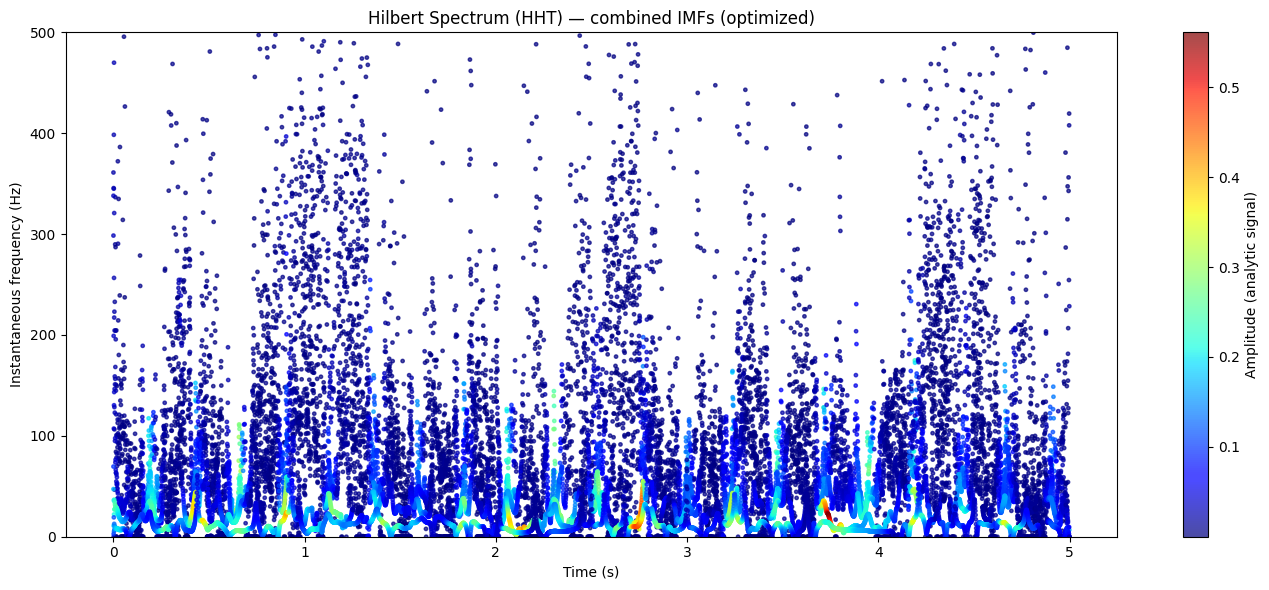

In [ ]:
# 6) Hilbert Spectrum (combined scatter)
plt.figure(figsize=(14,6))
if concat_time.size:
    sc = plt.scatter(concat_time, concat_freq, c=concat_amp, s=spectrum_point_size, cmap='jet', alpha=0.7)
    plt.colorbar(sc, label='Amplitude (analytic signal)')
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous frequency (Hz)')
plt.title('Hilbert Spectrum (HHT) — combined IMFs (optimized)')
plt.ylim(0, min(2000, fs_ds/2))
plt.tight_layout()
plt.show()

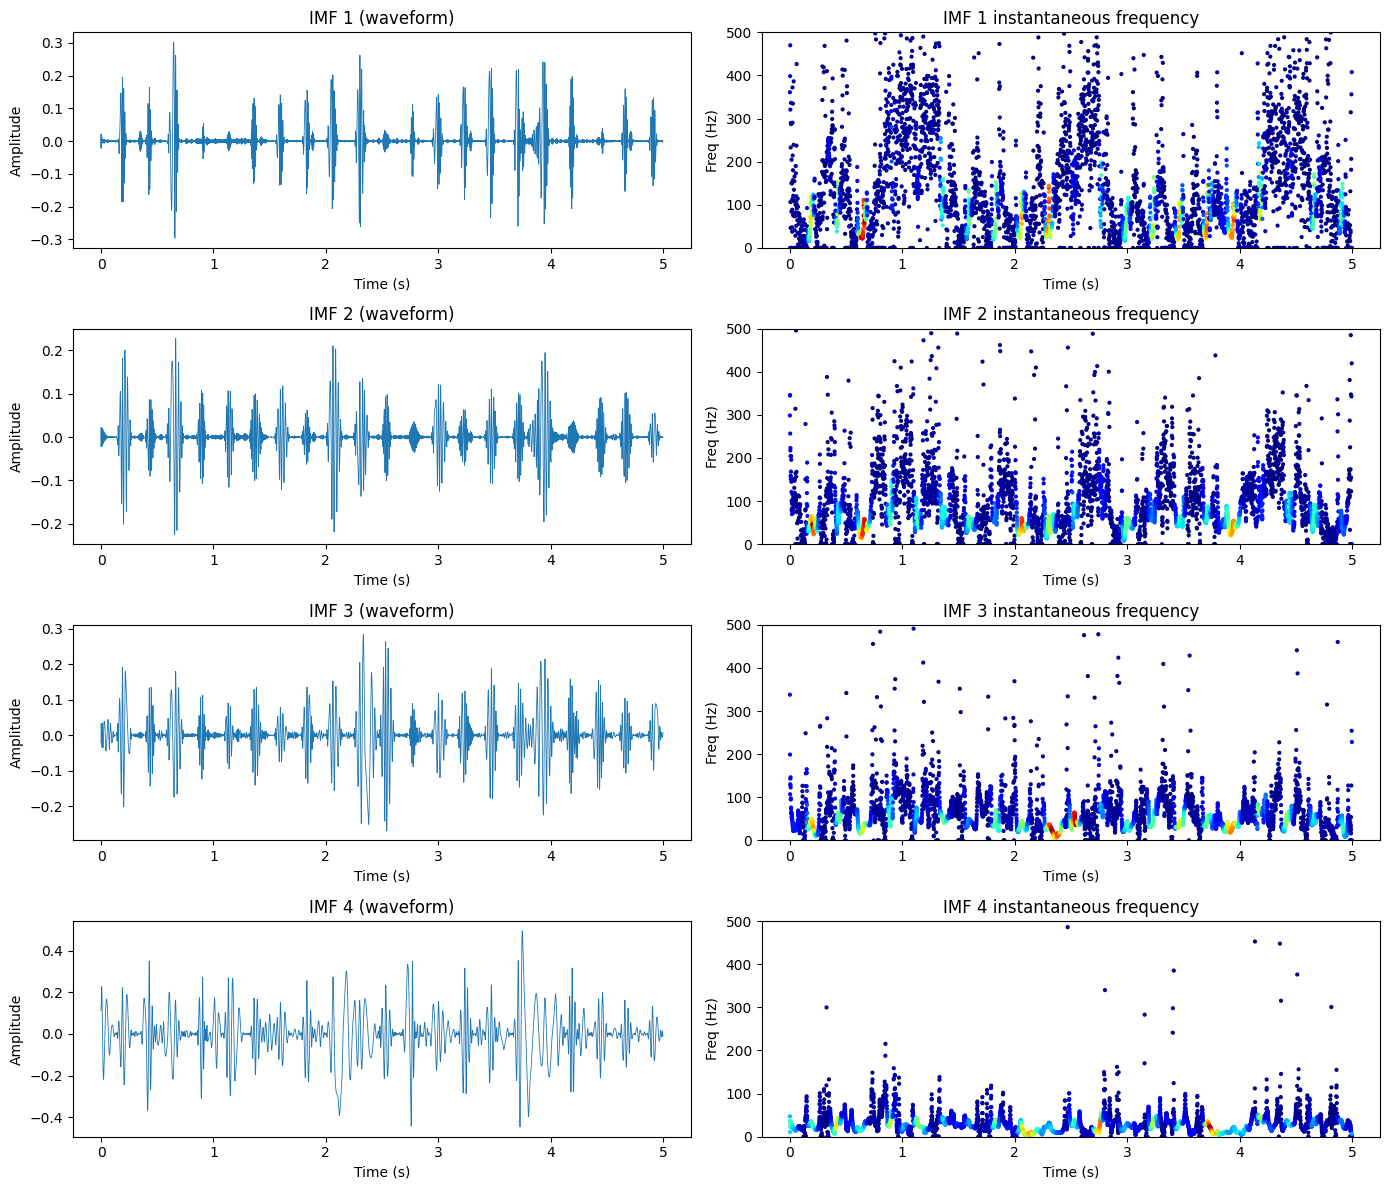

In [ ]:
# 7) Plot first few IMFs and their instantaneous frequencies
n_plot = min(n_imfs_to_plot, n_imfs)
if n_plot > 0:
    fig, axs = plt.subplots(n_plot, 2, figsize=(14, 3*n_plot), squeeze=False)
    for i in range(n_plot):
        imf = imfs[i]
        inst_time = all_inst_times[i]
        inst_freq = all_inst_freqs[i]
        amplitude = all_inst_amps[i]

        axs[i,0].plot(t_for_emd, imf, linewidth=0.6)
        axs[i,0].set_title(f'IMF {i+1} (waveform)')
        axs[i,0].set_xlabel('Time (s)')
        axs[i,0].set_ylabel('Amplitude')

        axs[i,1].scatter(inst_time, inst_freq, c=amplitude, s=4, cmap='jet')
        axs[i,1].set_title(f'IMF {i+1} instantaneous frequency')
        axs[i,1].set_xlabel('Time (s)')
        axs[i,1].set_ylabel('Freq (Hz)')
        axs[i,1].set_ylim(0, min(2000, fs_ds/2))

    plt.tight_layout()
    plt.show()

# **Task 3 — Hilbert–Huang Transform (HHT) Report**

## **1. Objective**

The purpose of this task is to apply the **Hilbert–Huang Transform (HHT)** on respiratory audio signals.  
HHT is useful for analyzing **non-linear, non-stationary biomedical signals**, such as wheezes and crackles.

The task includes two major steps:

### **A. EMD (Empirical Mode Decomposition)**  
- Decomposes the signal into **Intrinsic Mode Functions (IMFs)**.  
- Each IMF represents an oscillatory component of the signal.  
- Helps separate breathing patterns, crackles, wheezes, etc.

### **B. Hilbert Transform**
- Computes the **analytic signal** of each IMF.  
- Extracts **instantaneous frequency** and **instantaneous amplitude**.  
- Used to generate the **Hilbert Spectrum**.

---

## **2. Summary of the Process**

1. **Load the respiratory sound**.  
2. **Normalize → trim → downsample** the signal (speeds up EMD).  
3. **Run EMD** to extract IMFs.  
4. Apply **Hilbert Transform** to each IMF.  
5. Extract:
   - Amplitude  
   - Instantaneous phase  
   - Instantaneous frequency  
6. Plot the **Hilbert Spectrum** (time vs frequency, colored by amplitude).  
7. Plot the **first few IMFs** individually with their instantaneous frequency.

---

## **3. HHT Output Description**

### **A. Hilbert Spectrum (Time–Frequency Representation)**

The scatter plot shows:

- **X-axis:** Time (s)  
- **Y-axis:** Instantaneous frequency (Hz)  
- **Color:** Amplitude of the IMF  

#### **Interpretation**
- **Dense, low-frequency clusters → normal breathing**  
- **High-frequency bursts → possible crackles**  
- **Narrow, stable frequency lines → wheezes**  

A strong low-frequency region under **< 100 Hz** is typical for respiration.

---

### **B. IMF Waveforms and Instantaneous Frequency**

Each IMF plot contains:

- **Left:** The raw IMF waveform  
- **Right:** Instantaneous frequency  

#### **Interpretation**
- **IMF 1:**  
  - Highest-frequency content  
  - Usually captures crackles or noise  
- **IMF 2:**  
  - Medium-frequency oscillations  
  - Often corresponds to breathing energy or wheezes  

These plots help visualize where high-frequency respiratory events occur.

---

## **4. Optimized HHT Code (Summary Note)**

The optimized implementation includes:

- Safe downsampling using `resample_poly()`  
- Trimming the signal using `max_duration`  
- Faster EMD execution  
- Reduced Hilbert spectrum resolution  
- Efficient IMF plotting  


